In [1]:
import copy
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<h2>Load Data</h2>

In [3]:
weather_data = pd.read_csv('/content/drive/MyDrive/softcom/main22.csv')

In [4]:
weather_data

,date,station,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
0,1953-01-01,Dhaka,25.18,10.92,10,1.65,70.48,1.433178,6.427503
1,1953-02-01,Dhaka,29.52,14.74,2,2.07,64.50,1.433178,6.427503
2,1953-03-01,Dhaka,32.65,21.70,90,3.74,73.48,1.433178,6.427503
3,1953-04-01,Dhaka,35.02,23.44,90,3.37,68.83,1.433178,6.427503
4,1953-05-01,Dhaka,32.77,24.19,274,5.84,80.74,1.433178,6.427503
...,...,...,...,...,...,...,...,...,...
6643,2022-08-01,Barisal,32.91,26.26,331,5.77,84.84,2.710000,5.620000
6644,2022-09-01,Barisal,32.85,25.91,278,5.20,87.03,1.080000,4.500000
6645,2022-10-01,Barisal,32.41,23.66,476,2.84,85.32,0.990000,7.320000
6646,2022-11-01,Barisal,30.91,18.14,0,1.17,81.03,0.330000,8.730000


In [5]:
weather_data = weather_data[['date', 'station', 'max_temp', 'min_temp', 'rainfall', 'cloud', 'humidity', 'wind_speed', 'sunshine']]
dhaka = weather_data[weather_data['station'] == 'Dhaka']
raj = weather_data[weather_data['station'] == 'Rajshahi']
khulna = weather_data[weather_data['station'] == 'Khulna']
mymen = weather_data[weather_data['station'] == 'Mymensingh']
chitt = weather_data[weather_data['station'] == 'Chittagong']
syl = weather_data[weather_data['station'] == 'Sylhet']
rang = weather_data[weather_data['station'] == 'Rangpur']
bar = weather_data[weather_data['station'] == 'Barisal']

In [6]:
dhaka.tail(5)

,date,station,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
835,2022-08-01,Dhaka,34.21,27.36,130,5.45,75.03,3.10,5.40
836,2022-09-01,Dhaka,33.21,26.68,282,5.80,80.97,2.24,3.64
837,2022-10-01,Dhaka,32.72,24.91,297,3.71,73.97,2.22,5.51
838,2022-11-01,Dhaka,31.04,20.77,0,1.70,63.77,2.05,5.99
839,2022-12-01,Dhaka,27.41,17.24,4,0.52,69.23,1.89,4.45


In [7]:
dhaka.shape

(840, 9)

In [8]:
raj.shape

(708, 9)

<h1>EDA Plot</h1>

Dhaka


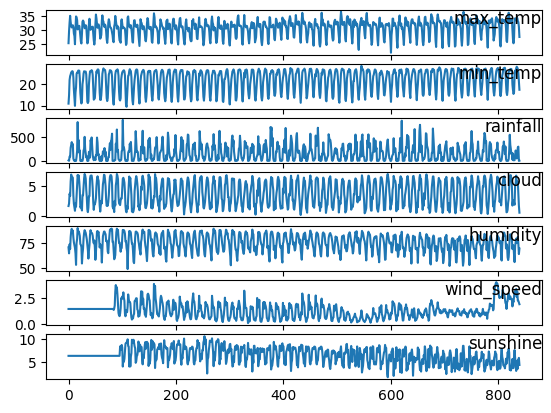

Rajshahi


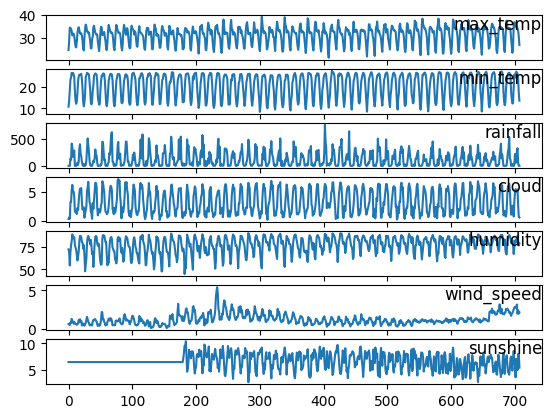

Khulna


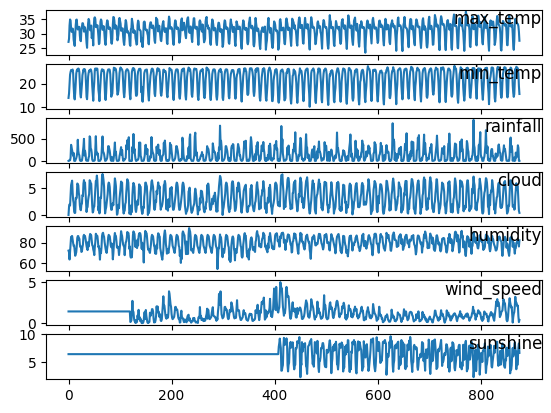

Mymensingh


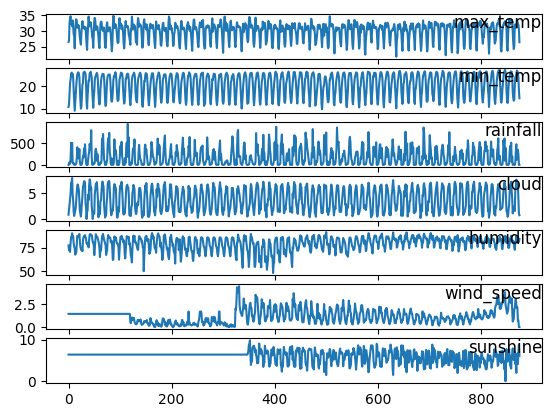

Rangpur


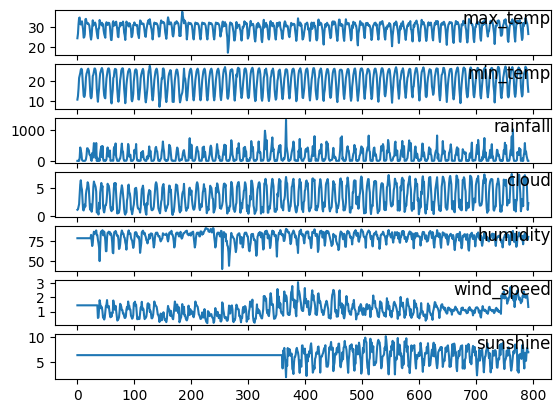

Sylhet


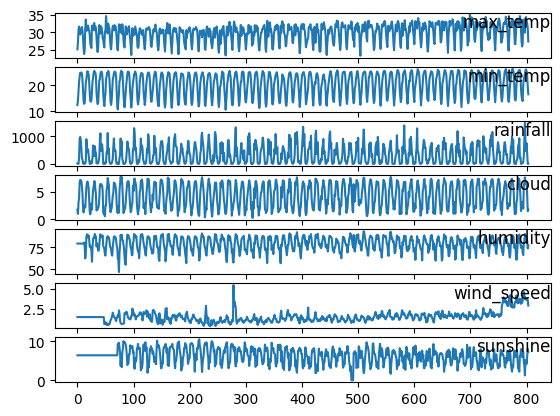

Chittagong


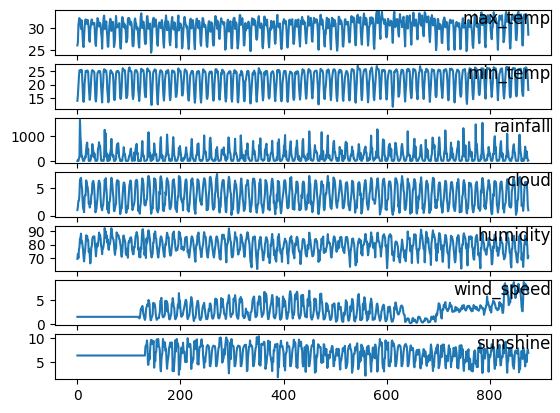

Barisal


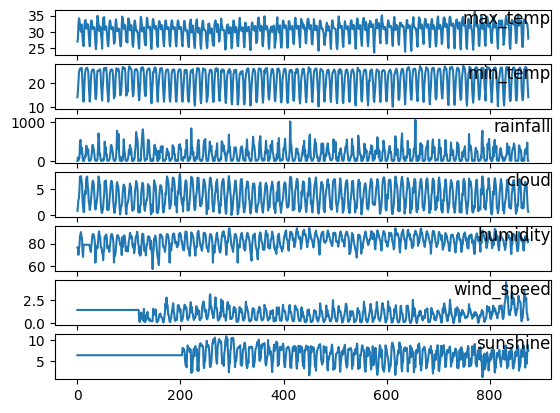

In [9]:
# time series plot of each feature over time
for city in [dhaka,raj,khulna,mymen,rang,syl,chitt,bar]:
    print(city['station'].iloc[0])
    values = city.values

    groups = [2, 3, 4, 5, 6, 7, 8]
    i = 1

    plt.figure()
    for group in groups:
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(city.columns[group], y=0.5, loc='right')
        i += 1
    plt.show()

<h2>Scaling the Data and Supervised Data</h2>

In [10]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).astype(float)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [11]:
dhaka = dhaka.set_index('date').drop(columns=['station'])
raj = raj.set_index('date').drop(columns=['station'])
khulna = khulna.set_index('date').drop(columns=['station'])
mymen = mymen.set_index('date').drop(columns=['station'])
chitt = chitt.set_index('date').drop(columns=['station'])
syl = syl.set_index('date').drop(columns=['station'])
rang = rang.set_index('date').drop(columns=['station'])
bar = bar.set_index('date').drop(columns=['station'])

In [12]:
#1 mnth 1 feat
# transform daily weather data into supervised data, with 1 month's data used to make predictions
def make_supervised(data):
    data_sup = series_to_supervised(data, n_in=7, n_out=1)  # Set n_out to 1
    drop_cols = ['var2(t)', 'var3(t)', 'var4(t)','var5(t)','var6(t)', 'var7(t)']

    for t in range(1, 1):
        for feat in range(1, 7):
            if not (feat == 1):
               drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)

   # if len(data_sup) != len(data) - 13:
    #    print(f"Length mismatch: Expected {len(data) - 13} rows, received {len(data_sup)}")

    return data_sup

In [13]:
# Split the data into train, validation, and test sets
train_size = int(len(dhaka) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(dhaka) * 0.10)
test_size = len(dhaka) - train_size - validation_size

dhaka_train, dhaka_validation, dhaka_test = \
    dhaka[0:train_size], dhaka[train_size:train_size+validation_size], dhaka[train_size+validation_size:]



In [14]:
dhaka_train_sup = make_supervised(dhaka_train)
dhaka_validation_sup = make_supervised(dhaka_validation)
dhaka_test_sup = make_supervised(dhaka_test)

In [15]:
dhaka_train_sup

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var6(t-2),var7(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
date,,,,,,,,,,,,,,,,,,,,,
1953-08-01,25.18,10.92,10.0,1.65,70.48,1.433178,6.427503,29.52,14.74,2.0,...,1.433178,6.427503,30.83,25.42,392.0,6.65,88.90,1.433178,6.427503,31.39
1953-09-01,29.52,14.74,2.0,2.07,64.50,1.433178,6.427503,32.65,21.70,90.0,...,1.433178,6.427503,31.39,25.72,326.0,6.58,85.55,1.433178,6.427503,31.63
1953-10-01,32.65,21.70,90.0,3.74,73.48,1.433178,6.427503,35.02,23.44,90.0,...,1.433178,6.427503,31.63,25.49,352.0,6.47,87.20,1.433178,6.427503,30.98
1953-11-01,35.02,23.44,90.0,3.37,68.83,1.433178,6.427503,32.77,24.19,274.0,...,1.433178,6.427503,30.98,22.88,52.0,3.45,80.35,1.433178,6.427503,28.64
1953-12-01,32.77,24.19,274.0,5.84,80.74,1.433178,6.427503,31.36,25.13,333.0,...,1.433178,6.427503,28.64,17.18,13.0,2.03,75.40,1.433178,6.427503,27.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-01,24.46,14.48,23.0,2.10,70.22,0.870000,4.680000,26.07,15.20,56.0,...,1.490000,4.170000,31.77,26.35,563.0,7.03,83.61,1.320000,3.100000,32.12
2008-09-01,26.07,15.20,56.0,1.69,62.16,0.830000,6.570000,31.65,21.96,45.0,...,1.320000,3.100000,32.12,26.49,319.0,6.39,82.22,0.830000,4.040000,32.57
2008-10-01,31.65,21.96,45.0,3.87,67.70,1.110000,5.920000,34.48,24.51,91.0,...,0.830000,4.040000,32.57,26.24,279.0,5.87,81.42,0.720000,4.410000,31.40


In [16]:
def x_y_split(data):
    y_cols = ['var1(t)']
    x_data = data.drop(columns=y_cols)
    y_data = data[y_cols].values
    return x_data, y_data

In [17]:
x_train_dhaka, y_train_dhaka = x_y_split(dhaka_train_sup)
x_validation_dhaka, y_validation_dhaka = x_y_split(dhaka_validation_sup)
x_test_dhaka, y_test_dhaka = x_y_split(dhaka_test_sup)

In [18]:
# reshape into (num_days, num_timesteps, num_features)

def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.shape[0], 7, 7))
    x_validation = x_validation.values.reshape((x_validation.shape[0], 7, 7))
    x_test = x_test.values.reshape((x_test.shape[0], 7, 7))
    return x_train, x_validation, x_test


In [19]:
x_train_dhaka, x_validation_dhaka, x_test_dhaka = reshape_data(x_train_dhaka, x_validation_dhaka, x_test_dhaka)

In [20]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models

In [21]:
print(x_train_dhaka.shape)
print(y_train_dhaka.shape)

(665, 7, 7)
(665, 1)


In [22]:

def fit_lstm(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=(7, 7)))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(32, activation='relu'))

    model.add(layers.Dense(1))  # Adjust output units to 1 for single-feature prediction
    model.compile(loss='mae', optimizer='adam')
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=150, batch_size=64,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping],
                        verbose=0, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model

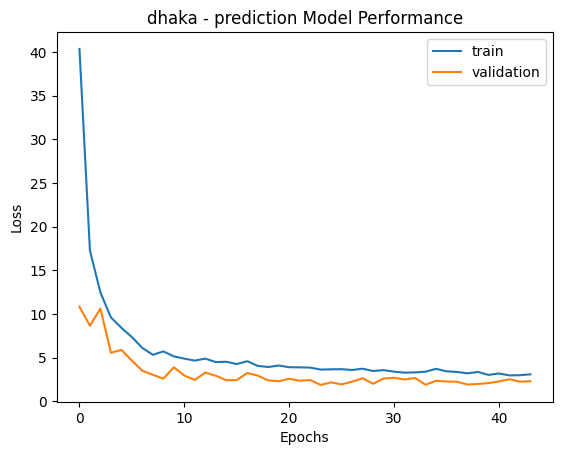

In [23]:
# Train LSTM model
dhaka_model = fit_lstm('dhaka - prediction', x_train_dhaka, y_train_dhaka,
                       x_validation_dhaka, y_validation_dhaka)


In [24]:
# Make predictions
y_pred_train_dhaka = dhaka_model.predict(x_train_dhaka)
y_pred_validation_dhaka = dhaka_model.predict(x_validation_dhaka)
y_pred_test_dhaka = dhaka_model.predict(x_test_dhaka)

3/3 [==============================] - 0s 5ms/step


In [25]:
y_pred_train_dhaka

array([[32.2291  ],
       [32.01827 ],
       [33.467598],
       [31.579222],
       [27.594944],
       [26.01113 ],
       [31.267977],
       [34.803493],
       [33.329895],
       [31.577585],
       [31.578901],
       [31.439522],
       [33.168636],
       [26.709856],
       [36.700817],
       [25.378637],
       [24.557749],
       [28.541964],
       [28.114958],
       [31.704453],
       [31.889725],
       [33.13191 ],
       [30.491219],
       [30.829607],
       [32.54916 ],
       [30.526852],
       [33.65514 ],
       [27.119772],
       [26.950003],
       [30.06547 ],
       [30.997072],
       [31.387753],
       [33.238106],
       [32.912777],
       [32.365997],
       [32.98732 ],
       [36.534313],
       [31.290453],
       [34.163967],
       [33.325237],
       [28.034191],
       [25.83508 ],
       [27.779318],
       [34.25958 ],
       [32.62344 ],
       [34.00814 ],
       [31.440432],
       [29.64911 ],
       [29.471561],
       [34.2816  ],


In [26]:
y_pred_test_dhaka

array([[32.960964],
       [28.905   ],
       [31.447859],
       [25.530819],
       [25.77741 ],
       [27.31795 ],
       [30.12245 ],
       [30.595987],
       [31.44752 ],
       [32.42931 ],
       [31.208685],
       [32.57762 ],
       [30.031351],
       [30.695833],
       [31.398306],
       [32.256184],
       [35.08026 ],
       [27.003725],
       [26.68779 ],
       [31.921072],
       [32.88097 ],
       [31.71419 ],
       [30.146616],
       [33.71658 ],
       [32.816765],
       [33.18752 ],
       [29.731043],
       [24.866962],
       [25.782085],
       [30.384611],
       [31.16174 ],
       [30.863188],
       [31.656168],
       [30.425825],
       [27.634298],
       [29.898434],
       [30.211672],
       [31.395365],
       [32.695766],
       [25.015165],
       [27.459541],
       [25.894102],
       [25.990557],
       [32.016136],
       [31.041662],
       [32.360416],
       [31.363478],
       [30.400545],
       [32.683067],
       [31.222044],


In [27]:
dhaka_test

,max_temp,min_temp,rainfall,cloud,humidity,wind_speed,sunshine
date,,,,,,,
2016-01-01,24.87,14.15,3,0.97,68.87,1.19,5.05
2016-02-01,29.80,19.08,13,2.14,63.45,1.08,6.17
2016-03-01,33.11,22.56,55,2.74,59.58,1.28,7.14
2016-04-01,35.14,26.91,55,4.20,72.40,1.45,7.37
2016-05-01,33.68,24.90,212,5.13,74.48,1.43,5.76
...,...,...,...,...,...,...,...
2022-08-01,34.21,27.36,130,5.45,75.03,3.10,5.40
2022-09-01,33.21,26.68,282,5.80,80.97,2.24,3.64
2022-10-01,32.72,24.91,297,3.71,73.97,2.22,5.51


In [28]:
y_test_dhaka.shape

(77, 1)

In [29]:
y_pred_test_dhaka.shape

(77, 1)

In [30]:
# Evaluate the model (you may need to modify this based on your specific evaluation criteria)
train_mae = mean_absolute_error(y_train_dhaka, y_pred_train_dhaka)
validation_mae = mean_absolute_error(y_validation_dhaka, y_pred_validation_dhaka)
test_mae = mean_absolute_error(y_test_dhaka, y_pred_test_dhaka)

In [31]:
print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MAE: 2.00
Validation MAE: 1.87
Test MAE: 2.33


In [32]:
dates = dhaka_test.index[7:]

# Assuming y_test_dhaka and y_pred_test_dhaka should start from index 7 as well
y_test_dhaka = y_test_dhaka[7:]
y_pred_test_dhaka = y_pred_test_dhaka[7:]

In [33]:
print("Length of dates:", len(dates))
print("Length of y_test_dhaka:", len(y_test_dhaka))
print("Length of y_pred_test_dhaka:", len(y_pred_test_dhaka))

Length of dates: 77
Length of y_test_dhaka: 70
Length of y_pred_test_dhaka: 70


In [34]:
dhaka_test.shape

(84, 7)

In [35]:
y_test_dhaka

array([[30.48],
       [32.79],
       [34.5 ],
       [33.04],
       [31.98],
       [32.59],
       [33.08],
       [31.99],
       [30.19],
       [26.76],
       [23.6 ],
       [29.22],
       [33.32],
       [33.03],
       [32.33],
       [33.54],
       [32.79],
       [33.8 ],
       [34.13],
       [31.99],
       [30.29],
       [26.14],
       [27.17],
       [28.35],
       [31.51],
       [33.68],
       [34.59],
       [33.58],
       [32.97],
       [33.75],
       [33.34],
       [32.06],
       [30.32],
       [24.76],
       [24.02],
       [27.45],
       [32.29],
       [33.83],
       [33.39],
       [33.38],
       [33.02],
       [32.94],
       [33.54],
       [33.16],
       [30.77],
       [25.97],
       [25.58],
       [29.53],
       [34.47],
       [36.13],
       [34.97],
       [32.5 ],
       [32.84],
       [33.23],
       [33.89],
       [33.53],
       [30.  ],
       [26.51],
       [25.15],
       [27.15],
       [33.92],
       [34.1 ],
       [

Actual and Predicted Max Temperature Values:
    Date  Actual Max Temp  Predicted Max Temp
0  Day 1            30.48           30.595987
1  Day 2            32.79           31.447519
2  Day 3            34.50           32.429310
3  Day 4            33.04           31.208685
4  Day 5            31.98           32.577621
5  Day 6            32.59           30.031351
6  Day 7            33.08           30.695833


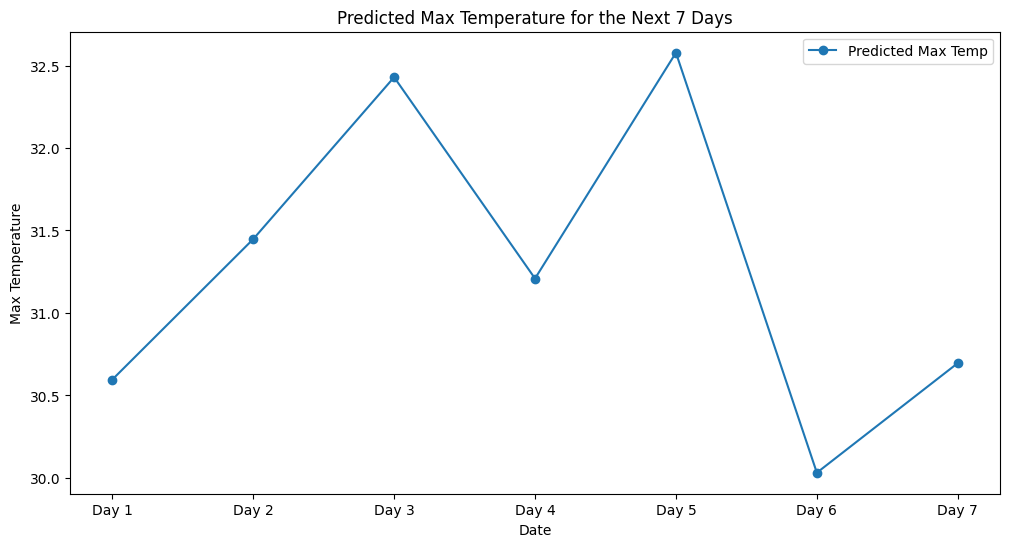

In [36]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = f"Day {i - len(dates) + 1}"  # You can modify this based on your requirement
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


Actual and Predicted Max Temperature Values:
    Date  Actual Max Temp  Predicted Max Temp
0  Day 1            30.48           30.595987
1  Day 2            32.79           31.447519
2  Day 3            34.50           32.429310
3  Day 4            33.04           31.208685
4  Day 5            31.98           32.577621
5  Day 6            32.59           30.031351
6  Day 7            33.08           30.695833


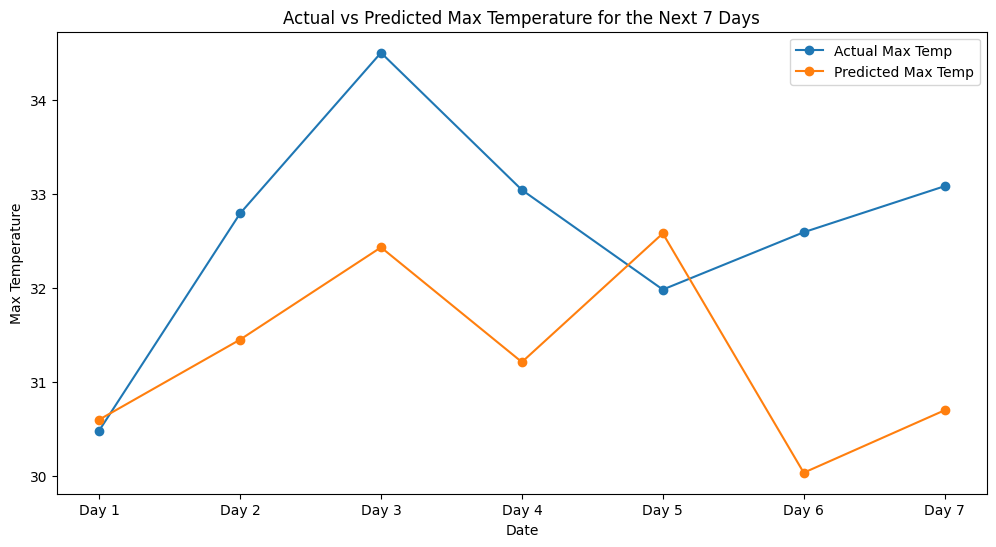

In [37]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = f"Day {i - len(dates) + 1}"  # You can modify this based on your requirement
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual Max Temp', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Actual vs Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


Actual and Predicted Max Temperature Values:
         Date  Actual Max Temp  Predicted Max Temp
0  2016-01-01            30.48           30.595987
1  2016-02-01            32.79           31.447519
2  2016-03-01            34.50           32.429310
3  2016-04-01            33.04           31.208685
4  2016-05-01            31.98           32.577621
5  2016-06-01            32.59           30.031351
6  2016-07-01            33.08           30.695833


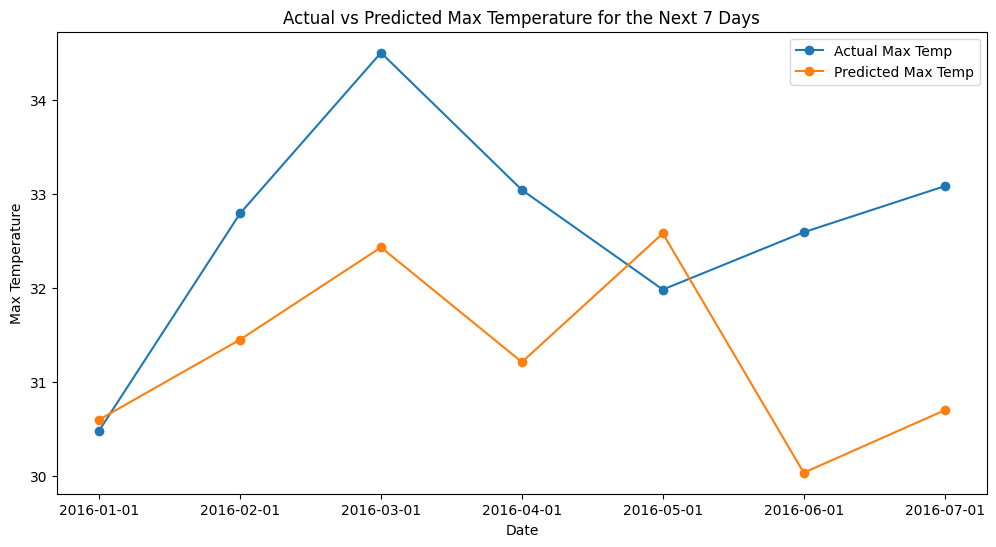

In [38]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 7

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_temp = y_test_dhaka[i - len(dates)][0]  # You won't have actual values for the future
    predicted_temp = y_pred_test_dhaka[i - len(dates)][0]  # Use double indexing to access the value

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_temp,
        'Predicted Max Temp': predicted_temp
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Max Temperature Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual Max Temp', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted Max Temp', marker='o')
plt.title("Actual vs Predicted Max Temperature for the Next 7 Days")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()
plt.show()


# **multiple target**


In [39]:
weather_data = pd.read_csv('/content/drive/MyDrive/softcom/main22.csv')

weather_data = weather_data[['date', 'station', 'max_temp', 'min_temp', 'rainfall', 'cloud', 'humidity', 'wind_speed', 'sunshine']]


dhaka = weather_data[weather_data['station'] == 'Dhaka']
raj = weather_data[weather_data['station'] == 'Rajshahi']
khulna = weather_data[weather_data['station'] == 'Khulna']
mymen = weather_data[weather_data['station'] == 'Mymensingh']
chitt = weather_data[weather_data['station'] == 'Chittagong']
syl = weather_data[weather_data['station'] == 'Sylhet']
rang = weather_data[weather_data['station'] == 'Rangpur']
bar = weather_data[weather_data['station'] == 'Barisal']
dhaka['date'] = pd.to_datetime(dhaka['date'])
raj['date'] = pd.to_datetime(raj['date'])
khulna['date'] = pd.to_datetime(khulna['date'])
mymen['date'] = pd.to_datetime(mymen['date'])
chitt['date'] = pd.to_datetime(chitt['date'])
syl['date'] = pd.to_datetime(syl['date'])
rang['date'] = pd.to_datetime(rang['date'])
bar['date'] = pd.to_datetime(bar['date'])


<ipython-input-39-8d6ca75158f4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dhaka['date'] = pd.to_datetime(dhaka['date'])
<ipython-input-39-8d6ca75158f4>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raj['date'] = pd.to_datetime(raj['date'])
<ipython-input-39-8d6ca75158f4>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [40]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data).astype(float)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
dhaka = dhaka.set_index('date').drop(columns=['station'])
mymen = mymen.set_index('date').drop(columns=['station'])
raj = raj.set_index('date').drop(columns=['station'])
khulna = khulna.set_index('date').drop(columns=['station'])
chitt = chitt.set_index('date').drop(columns=['station'])
rang = rang.set_index('date').drop(columns=['station'])
syl = syl.set_index('date').drop(columns=['station'])
bar = bar.set_index('date').drop(columns=['station'])

In [42]:

def make_supervised(data):
    data_sup = series_to_supervised(data, n_in=7, n_out=1)
    drop_cols = ['var2(t)', 'var4(t)', 'var6(t)', 'var7(t)']

    for t in range(1, 1):
        for feat in range(1, 7):
            if not (feat == 1 or feat == 3 or feat == 5):
               drop_cols.append(f'var{feat}(t+{t})')
    data_sup = data_sup.drop(columns=drop_cols)

    # data_sup = data_sup.set_index(data.index[13:])
    return data_sup


In [43]:
# Split the data into train, validation, and test sets
train_size = int(len(dhaka) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(dhaka) * 0.10)
test_size = len(dhaka) - train_size - validation_size

dhaka_train, dhaka_validation, dhaka_test = \
    dhaka[0:train_size], dhaka[train_size:train_size+validation_size], dhaka[train_size+validation_size:]



In [44]:
# Split the data into train, validation, and test sets
train_size = int(len(mymen) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(mymen) * 0.1)
test_size = len(mymen) - train_size - validation_size

mymen_train, mymen_validation, mymen_test = \
    mymen[0:train_size], mymen[train_size:train_size+validation_size], mymen[train_size+validation_size:]


In [45]:
# Split the data into train, validation, and test sets
train_size = int(len(raj) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(raj) * 0.1)
test_size = len(raj) - train_size - validation_size

raj_train, raj_validation, raj_test = \
    raj[0:train_size], raj[train_size:train_size+validation_size], raj[train_size+validation_size:]


In [46]:
# Split the data into train, validation, and test sets
train_size = int(len(khulna) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(khulna) * 0.1)
test_size = len(khulna) - train_size - validation_size

khulna_train, khulna_validation, khulna_test = \
    khulna[0:train_size], khulna[train_size:train_size+validation_size], khulna[train_size+validation_size:]


In [47]:
# Split the data into train, validation, and test sets
train_size = int(len(chitt) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(chitt) * 0.1)
test_size = len(chitt) - train_size - validation_size

chitt_train, chitt_validation, chitt_test = \
    chitt[0:train_size], chitt[train_size:train_size+validation_size], chitt[train_size+validation_size:]


In [48]:
# Split the data into train, validation, and test sets
train_size = int(len(rang) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(rang) * 0.1)
test_size = len(rang) - train_size - validation_size

rang_train, rang_validation, rang_test = \
    rang[0:train_size], rang[train_size:train_size+validation_size], rang[train_size+validation_size:]


In [49]:
# Split the data into train, validation, and test sets
train_size = int(len(syl) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(syl) * 0.1)
test_size = len(syl) - train_size - validation_size

syl_train, syl_validation, syl_test = \
    syl[0:train_size], syl[train_size:train_size+validation_size], syl[train_size+validation_size:]


In [50]:
# Split the data into train, validation, and test sets
train_size = int(len(bar) * 0.8)  # Adjust the split ratio as needed
validation_size = int(len(bar) * 0.1)
test_size = len(bar) - train_size - validation_size

bar_train, bar_validation, bar_test = \
    bar[0:train_size], bar[train_size:train_size+validation_size], bar[train_size+validation_size:]


In [51]:
dhaka_train_sup = make_supervised(dhaka_train)
dhaka_validation_sup = make_supervised(dhaka_validation)
dhaka_test_sup = make_supervised(dhaka_test)

In [52]:
mymen_train_sup = make_supervised(mymen_train)
mymen_validation_sup = make_supervised(mymen_validation)
mymen_test_sup = make_supervised(mymen_test)


In [53]:
raj_train_sup = make_supervised(raj_train)
raj_validation_sup = make_supervised(raj_validation)
raj_test_sup = make_supervised(raj_test)


In [54]:
khulna_train_sup = make_supervised(khulna_train)
khulna_validation_sup = make_supervised(khulna_validation)
khulna_test_sup = make_supervised(khulna_test)


In [55]:
chitt_train_sup = make_supervised(chitt_train)
chitt_validation_sup = make_supervised(chitt_validation)
chitt_test_sup = make_supervised(chitt_test)


In [56]:
rang_train_sup = make_supervised(rang_train)
rang_validation_sup = make_supervised(rang_validation)
rang_test_sup = make_supervised(rang_test)


In [57]:
syl_train_sup = make_supervised(syl_train)
syl_validation_sup = make_supervised(syl_validation)
syl_test_sup = make_supervised(syl_test)


In [58]:
bar_train_sup = make_supervised(bar_train)
bar_validation_sup = make_supervised(bar_validation)
bar_test_sup = make_supervised(bar_test)


In [59]:
dhaka_train_sup

,var1(t-7),var2(t-7),var3(t-7),var4(t-7),var5(t-7),var6(t-7),var7(t-7),var1(t-6),var2(t-6),var3(t-6),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t),var3(t),var5(t)
date,,,,,,,,,,,,,,,,,,,,,
1953-08-01,25.18,10.92,10.0,1.65,70.48,1.433178,6.427503,29.52,14.74,2.0,...,30.83,25.42,392.0,6.65,88.90,1.433178,6.427503,31.39,326.0,85.55
1953-09-01,29.52,14.74,2.0,2.07,64.50,1.433178,6.427503,32.65,21.70,90.0,...,31.39,25.72,326.0,6.58,85.55,1.433178,6.427503,31.63,352.0,87.20
1953-10-01,32.65,21.70,90.0,3.74,73.48,1.433178,6.427503,35.02,23.44,90.0,...,31.63,25.49,352.0,6.47,87.20,1.433178,6.427503,30.98,52.0,80.35
1953-11-01,35.02,23.44,90.0,3.37,68.83,1.433178,6.427503,32.77,24.19,274.0,...,30.98,22.88,52.0,3.45,80.35,1.433178,6.427503,28.64,13.0,75.40
1953-12-01,32.77,24.19,274.0,5.84,80.74,1.433178,6.427503,31.36,25.13,333.0,...,28.64,17.18,13.0,2.03,75.40,1.433178,6.427503,27.77,0.0,72.42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-01,24.46,14.48,23.0,2.10,70.22,0.870000,4.680000,26.07,15.20,56.0,...,31.77,26.35,563.0,7.03,83.61,1.320000,3.100000,32.12,319.0,82.22
2008-09-01,26.07,15.20,56.0,1.69,62.16,0.830000,6.570000,31.65,21.96,45.0,...,32.12,26.49,319.0,6.39,82.22,0.830000,4.040000,32.57,279.0,81.42
2008-10-01,31.65,21.96,45.0,3.87,67.70,1.110000,5.920000,34.48,24.51,91.0,...,32.57,26.24,279.0,5.87,81.42,0.720000,4.410000,31.40,227.0,78.29


In [60]:
def x_y_split(data):
    y_cols = ['var1(t)','var3(t)','var5(t)']
    x_data = data.drop(columns=y_cols)
    y_data = data[y_cols].values
    return x_data, y_data

In [61]:
x_train_dhaka, y_train_dhaka = x_y_split(dhaka_train_sup)
x_validation_dhaka, y_validation_dhaka = x_y_split(dhaka_validation_sup)
x_test_dhaka, y_test_dhaka = x_y_split(dhaka_test_sup)

In [62]:
x_train_mymen, y_train_mymen = x_y_split(mymen_train_sup)
x_validation_mymen, y_validation_mymen = x_y_split(mymen_validation_sup)
x_test_mymen, y_test_mymen = x_y_split(mymen_test_sup)


In [63]:
x_train_raj, y_train_raj = x_y_split(raj_train_sup)
x_validation_raj, y_validation_raj = x_y_split(raj_validation_sup)
x_test_raj, y_test_raj = x_y_split(raj_test_sup)


In [64]:
x_train_khulna, y_train_khulna = x_y_split(khulna_train_sup)
x_validation_khulna, y_validation_khulna = x_y_split(khulna_validation_sup)
x_test_khulna, y_test_khulna = x_y_split(khulna_test_sup)


In [65]:
x_train_chitt, y_train_chitt = x_y_split(chitt_train_sup)
x_validation_chitt, y_validation_chitt = x_y_split(chitt_validation_sup)
x_test_chitt, y_test_chitt = x_y_split(chitt_test_sup)


In [66]:
x_train_rang, y_train_rang = x_y_split(rang_train_sup)
x_validation_rang, y_validation_rang = x_y_split(rang_validation_sup)
x_test_rang, y_test_rang = x_y_split(rang_test_sup)


In [67]:
x_train_syl, y_train_syl = x_y_split(syl_train_sup)
x_validation_syl, y_validation_syl = x_y_split(syl_validation_sup)
x_test_syl, y_test_syl = x_y_split(syl_test_sup)


In [68]:
x_train_bar, y_train_bar = x_y_split(bar_train_sup)
x_validation_bar, y_validation_bar = x_y_split(bar_validation_sup)
x_test_bar, y_test_bar = x_y_split(bar_test_sup)


In [69]:
y_train_dhaka

array([[ 31.39, 326.  ,  85.55],
       [ 31.63, 352.  ,  87.2 ],
       [ 30.98,  52.  ,  80.35],
       ...,
       [ 31.4 , 227.  ,  78.29],
       [ 29.71,   0.  ,  69.94],
       [ 25.57,   0.  ,  79.76]])

In [70]:
# reshape into (num_days, num_timesteps, num_features)
def reshape_data(x_train, x_validation, x_test):
    x_train = x_train.values.reshape((x_train.shape[0], 7, 7))
    x_validation = x_validation.values.reshape((x_validation.shape[0], 7, 7))
    x_test = x_test.values.reshape((x_test.shape[0], 7, 7))
    return x_train, x_validation, x_test

In [71]:
x_train_dhaka, x_validation_dhaka, x_test_dhaka = reshape_data(x_train_dhaka, x_validation_dhaka, x_test_dhaka)
x_train_mymen, x_validation_mymen, x_test_mymen = reshape_data(x_train_mymen, x_validation_mymen, x_test_mymen)
x_train_raj, x_validation_raj, x_test_raj = reshape_data(x_train_raj, x_validation_raj, x_test_raj)
x_train_khulna, x_validation_khulna, x_test_khulna = reshape_data(x_train_khulna, x_validation_khulna, x_test_khulna)
x_train_chitt, x_validation_chitt, x_test_chitt = reshape_data(x_train_chitt, x_validation_chitt, x_test_chitt)
x_train_rang, x_validation_rang, x_test_rang = reshape_data(x_train_rang, x_validation_rang, x_test_rang)
x_train_syl, x_validation_syl, x_test_syl = reshape_data(x_train_syl, x_validation_syl, x_test_syl)
x_train_bar, x_validation_bar, x_test_bar = reshape_data(x_train_bar, x_validation_bar, x_test_bar)


In [72]:
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

def fit_lstm(model_name, x_train, y_train, x_validation, y_validation):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(7, 7)))
    model.add(MaxPooling1D(pool_size=2))
    #model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(32, activation='relu'))

    model.add(Dense(3))  # Adjust output units to 3 for three-feature prediction

    # Use the Adam optimizer with a lower learning rate
    optimizer = Adam(learning_rate=0.001)

    model.compile(loss='mae', optimizer=optimizer)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(x_train, y_train, epochs=200, batch_size=32,
                        validation_data=(x_validation, y_validation),
                        callbacks=[early_stopping],
                        verbose=0, shuffle=False)

    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(f"{model_name} Model Performance")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model


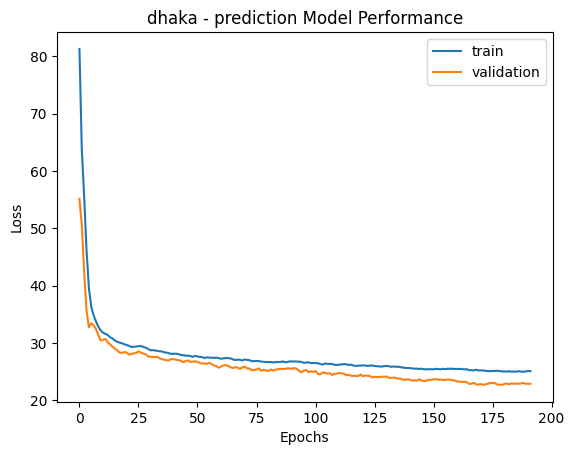

In [73]:
# Train LSTM model
dhaka_model = fit_lstm('dhaka - prediction', x_train_dhaka, y_train_dhaka,
                       x_validation_dhaka, y_validation_dhaka)

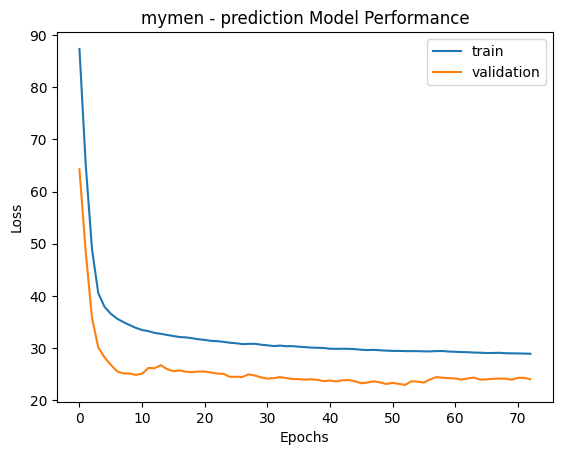

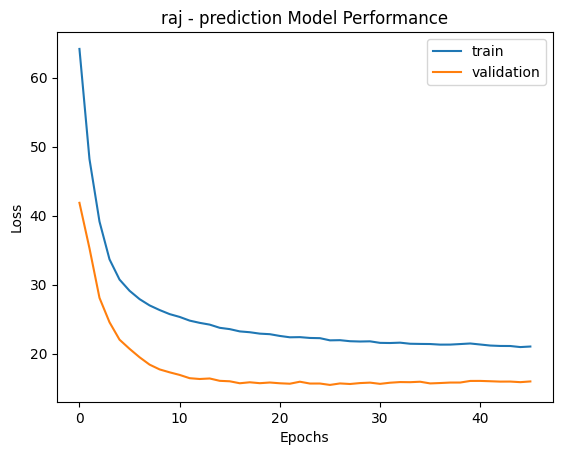

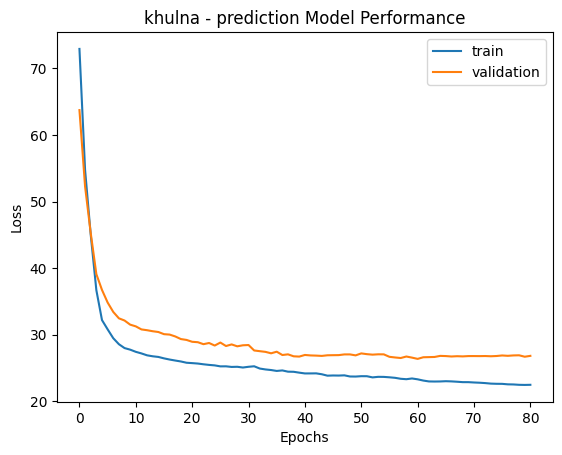

In [74]:

mymen_model = fit_lstm('mymen - prediction', x_train_mymen, y_train_mymen,
                       x_validation_mymen, y_validation_mymen)
raj_model = fit_lstm('raj - prediction', x_train_raj, y_train_raj,
                     x_validation_raj, y_validation_raj)
khulna_model = fit_lstm('khulna - prediction', x_train_khulna, y_train_khulna,
                        x_validation_khulna, y_validation_khulna)


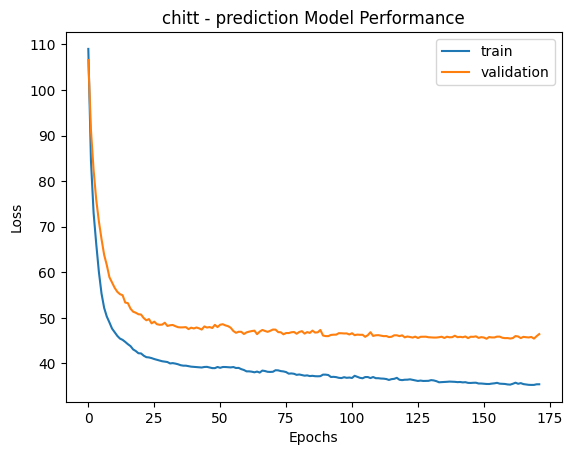

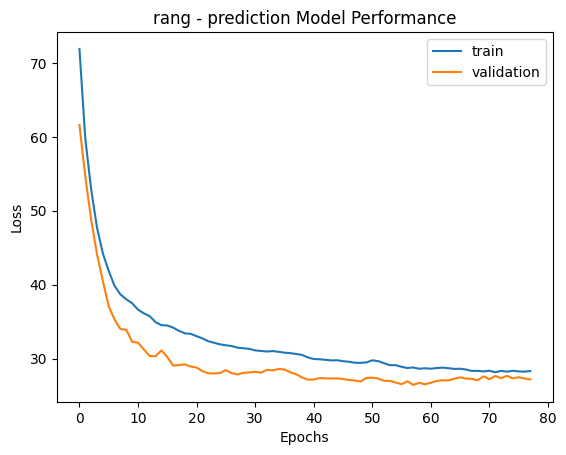

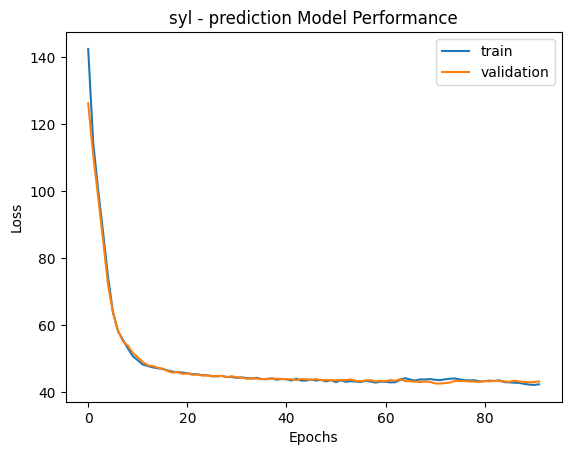

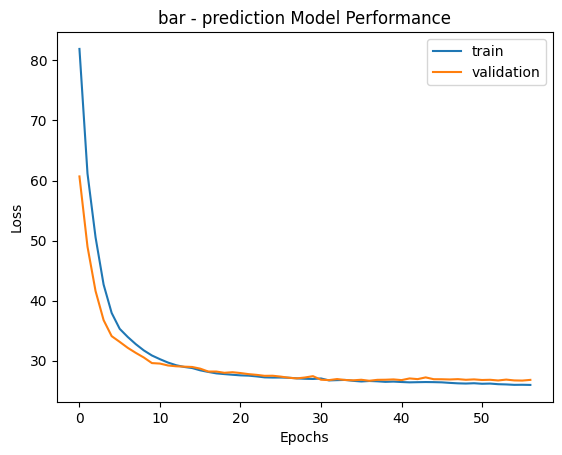

In [75]:
chitt_model = fit_lstm('chitt - prediction', x_train_chitt, y_train_chitt,
                       x_validation_chitt, y_validation_chitt)
rang_model = fit_lstm('rang - prediction', x_train_rang, y_train_rang,
                      x_validation_rang, y_validation_rang)
syl_model = fit_lstm('syl - prediction', x_train_syl, y_train_syl,
                     x_validation_syl, y_validation_syl)
bar_model = fit_lstm('bar - prediction', x_train_bar, y_train_bar,
                     x_validation_bar, y_validation_bar)


In [76]:
# Make predictions
y_pred_train_dhaka = dhaka_model.predict(x_train_dhaka)
y_pred_validation_dhaka = dhaka_model.predict(x_validation_dhaka)
y_pred_test_dhaka = dhaka_model.predict(x_test_dhaka)

3/3 [==============================] - 0s 4ms/step


In [77]:
y_pred_train_mymen = mymen_model.predict(x_train_mymen)
y_pred_validation_mymen = mymen_model.predict(x_validation_mymen)
y_pred_test_mymen = mymen_model.predict(x_test_mymen)


3/3 [==============================] - 0s 4ms/step


In [78]:
y_pred_train_raj = raj_model.predict(x_train_raj)
y_pred_validation_raj = raj_model.predict(x_validation_raj)
y_pred_test_raj = raj_model.predict(x_test_raj)


3/3 [==============================] - 0s 4ms/step


In [79]:
y_pred_train_khulna = khulna_model.predict(x_train_khulna)
y_pred_validation_khulna = khulna_model.predict(x_validation_khulna)
y_pred_test_khulna = khulna_model.predict(x_test_khulna)


3/3 [==============================] - 0s 4ms/step


In [80]:
y_pred_train_chitt = chitt_model.predict(x_train_chitt)
y_pred_validation_chitt = chitt_model.predict(x_validation_chitt)
y_pred_test_chitt = chitt_model.predict(x_test_chitt)


3/3 [==============================] - 0s 4ms/step


In [81]:
y_pred_train_rang = rang_model.predict(x_train_rang)
y_pred_validation_rang = rang_model.predict(x_validation_rang)
y_pred_test_rang = rang_model.predict(x_test_rang)


3/3 [==============================] - 0s 4ms/step


In [82]:
y_pred_train_syl = syl_model.predict(x_train_syl)
y_pred_validation_syl = syl_model.predict(x_validation_syl)
y_pred_test_syl = syl_model.predict(x_test_syl)


3/3 [==============================] - 0s 4ms/step


In [83]:
y_pred_train_bar = bar_model.predict(x_train_bar)
y_pred_validation_bar = bar_model.predict(x_validation_bar)
y_pred_test_bar = bar_model.predict(x_test_bar)


3/3 [==============================] - 0s 4ms/step


In [84]:
y_test_dhaka

array([[ 33.28, 171.  ,  77.74],
       [ 32.87, 138.  ,  82.13],
       [ 33.07,  76.  ,  74.77],
       [ 29.6 ,  25.  ,  73.  ],
       [ 27.76,   0.  ,  72.29],
       [ 26.37,   0.  ,  62.84],
       [ 29.57,   2.  ,  57.21],
       [ 30.48, 100.  ,  67.16],
       [ 32.79, 228.  ,  72.97],
       [ 34.5 , 188.  ,  73.23],
       [ 33.04, 414.  ,  80.2 ],
       [ 31.98, 584.  ,  83.84],
       [ 32.59, 544.  ,  83.06],
       [ 33.08, 381.  ,  82.2 ],
       [ 31.99, 412.  ,  79.87],
       [ 30.19,   6.  ,  67.73],
       [ 26.76,  33.  ,  76.61],
       [ 23.6 ,   0.  ,  68.97],
       [ 29.22,  20.  ,  61.54],
       [ 33.32,   3.  ,  59.77],
       [ 33.03, 309.  ,  69.67],
       [ 32.33, 392.  ,  79.16],
       [ 33.54, 366.  ,  81.53],
       [ 32.79, 354.  ,  81.71],
       [ 33.8 , 141.  ,  78.03],
       [ 34.13,  76.  ,  77.33],
       [ 31.99,  45.  ,  72.23],
       [ 30.29,  13.  ,  68.7 ],
       [ 26.14,  13.  ,  66.13],
       [ 27.17,   1.  ,  59.97],
       [ 2

In [85]:
y_pred_test_dhaka

array([[ 32.327896 , 291.01315  ,  79.94754  ],
       [ 32.548367 , 245.42241  ,  78.38385  ],
       [ 31.522564 , 171.37798  ,  79.55605  ],
       [ 30.826773 ,  77.066956 ,  72.878105 ],
       [ 25.281239 ,  13.511308 ,  70.54115  ],
       [ 25.315903 ,  17.029016 ,  65.66363  ],
       [ 27.647902 ,  32.432148 ,  62.724285 ],
       [ 30.037907 ,  70.84828  ,  63.833794 ],
       [ 34.291756 , 138.19655  ,  66.38488  ],
       [ 32.345886 , 251.69568  ,  73.034325 ],
       [ 31.806938 , 343.1746   ,  80.92578  ],
       [ 31.684841 , 313.79254  ,  81.088264 ],
       [ 31.54034  , 273.52087  ,  79.181175 ],
       [ 30.661575 , 254.43275  ,  81.38615  ],
       [ 30.233025 , 109.989655 ,  72.70398  ],
       [ 31.998161 ,  57.14702  ,  75.580635 ],
       [ 29.87352  ,  21.543676 ,  74.18187  ],
       [ 24.57381  ,   7.938777 ,  71.07659  ],
       [ 24.975384 ,  22.00983  ,  67.793495 ],
       [ 29.127232 ,  26.243889 ,  63.18274  ],
       [ 33.224754 ,  43.98063  ,  64.13

In [86]:
# Evaluate the model (you may need to modify this based on your specific evaluation criteria)
train_mae = mean_absolute_error(y_train_dhaka, y_pred_train_dhaka)
validation_mae = mean_absolute_error(y_validation_dhaka, y_pred_validation_dhaka)
test_mae = mean_absolute_error(y_test_dhaka, y_pred_test_dhaka)

print(f"Train MAE: {train_mae:.2f}")
print(f"Validation MAE: {validation_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Train MAE: 25.24
Validation MAE: 22.66
Test MAE: 25.68


In [87]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Root Mean Squared Error (RMSE)
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred, epsilon=1e-10):
    mask = y_true > epsilon  # Filter out instances where true values are close to zero
    y_true, y_pred = np.array(y_true)[mask], np.array(y_pred)[mask]
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Function to calculate metrics for a city
def calculate_metrics(y_true, y_pred, city_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print(f"{city_name} Metrics:")
    print(f"MAE: {mae:.2f}")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print("\n")



In [88]:
# Calculate metrics for Dhaka
calculate_metrics(y_train_dhaka, y_pred_train_dhaka, "Dhaka (Train)")
calculate_metrics(y_validation_dhaka, y_pred_validation_dhaka, "Dhaka (Validation)")
calculate_metrics(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

Dhaka (Train) Metrics:
MAE: 25.24
MSE: 4003.45
RMSE: 63.27
MAPE: 49.71%


Dhaka (Validation) Metrics:
MAE: 22.66
MSE: 2386.21
RMSE: 48.85
MAPE: 70.35%


Dhaka (Test) Metrics:
MAE: 25.68
MSE: 3739.13
RMSE: 61.15
MAPE: 60.00%




In [89]:
# Calculate metrics for Dhaka
calculate_metrics(y_train_dhaka, y_pred_train_dhaka, "Dhaka (Train)")
calculate_metrics(y_validation_dhaka, y_pred_validation_dhaka, "Dhaka (Validation)")
calculate_metrics(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

# Calculate metrics for MyMensingh
calculate_metrics(y_train_mymen, y_pred_train_mymen, "MyMensingh (Train)")
calculate_metrics(y_validation_mymen, y_pred_validation_mymen, "MyMensingh (Validation)")
calculate_metrics(y_test_mymen, y_pred_test_mymen, "MyMensingh (Test)")

# Calculate metrics for Rajshahi
calculate_metrics(y_train_raj, y_pred_train_raj, "Rajshahi (Train)")
calculate_metrics(y_validation_raj, y_pred_validation_raj, "Rajshahi (Validation)")
calculate_metrics(y_test_raj, y_pred_test_raj, "Rajshahi (Test)")

# Calculate metrics for Khulna
calculate_metrics(y_train_khulna, y_pred_train_khulna, "Khulna (Train)")
calculate_metrics(y_validation_khulna, y_pred_validation_khulna, "Khulna (Validation)")
calculate_metrics(y_test_khulna, y_pred_test_khulna, "Khulna (Test)")

# Calculate metrics for Chittagong
calculate_metrics(y_train_chitt, y_pred_train_chitt, "Chittagong (Train)")
calculate_metrics(y_validation_chitt, y_pred_validation_chitt, "Chittagong (Validation)")
calculate_metrics(y_test_chitt, y_pred_test_chitt, "Chittagong (Test)")

# Calculate metrics for Rangpur
calculate_metrics(y_train_rang, y_pred_train_rang, "Rangpur (Train)")
calculate_metrics(y_validation_rang, y_pred_validation_rang, "Rangpur (Validation)")
calculate_metrics(y_test_rang, y_pred_test_rang, "Rangpur (Test)")

# Calculate metrics for Sylhet
calculate_metrics(y_train_syl, y_pred_train_syl, "Sylhet (Train)")
calculate_metrics(y_validation_syl, y_pred_validation_syl, "Sylhet (Validation)")
calculate_metrics(y_test_syl, y_pred_test_syl, "Sylhet (Test)")

# Calculate metrics for Barisal
calculate_metrics(y_train_bar, y_pred_train_bar, "Barisal (Train)")
calculate_metrics(y_validation_bar, y_pred_validation_bar, "Barisal (Validation)")
calculate_metrics(y_test_bar, y_pred_test_bar, "Barisal (Test)")


Dhaka (Train) Metrics:
MAE: 25.24
MSE: 4003.45
RMSE: 63.27
MAPE: 49.71%


Dhaka (Validation) Metrics:
MAE: 22.66
MSE: 2386.21
RMSE: 48.85
MAPE: 70.35%


Dhaka (Test) Metrics:
MAE: 25.68
MSE: 3739.13
RMSE: 61.15
MAPE: 60.00%


MyMensingh (Train) Metrics:
MAE: 29.32
MSE: 5608.05
RMSE: 74.89
MAPE: 65.95%


MyMensingh (Validation) Metrics:
MAE: 22.92
MSE: 2983.83
RMSE: 54.62
MAPE: 89.82%


MyMensingh (Test) Metrics:
MAE: 28.14
MSE: 4601.60
RMSE: 67.84
MAPE: 52.94%


Rajshahi (Train) Metrics:
MAE: 21.72
MSE: 3066.81
RMSE: 55.38
MAPE: 52.23%


Rajshahi (Validation) Metrics:
MAE: 15.45
MSE: 1248.31
RMSE: 35.33
MAPE: 59.95%


Rajshahi (Test) Metrics:
MAE: 19.26
MSE: 1901.49
RMSE: 43.61
MAPE: 95.08%


Khulna (Train) Metrics:
MAE: 22.96
MSE: 3374.20
RMSE: 58.09
MAPE: 44.82%


Khulna (Validation) Metrics:
MAE: 26.36
MSE: 4739.22
RMSE: 68.84
MAPE: 85.99%


Khulna (Test) Metrics:
MAE: 26.84
MSE: 3763.89
RMSE: 61.35
MAPE: 66.25%


Chittagong (Train) Metrics:
MAE: 35.45
MSE: 8984.22
RMSE: 94.79
MAPE:

In [90]:
cities = ['Dhaka', 'Mymen', 'Raj', 'Khulna', 'Chitt', 'Rang', 'Syl', 'Bar']

for city in cities:
    dates_city = eval(f'{city.lower()}_test.index')
    y_test_city = eval(f'y_test_{city.lower()}')
    y_pred_test_city = eval(f'y_pred_test_{city.lower()}')

    print(f"Length of dates ({city}):", len(dates_city))
    print(f"Length of y_test_{city.lower()}:", len(y_test_city))
    print(f"Length of y_pred_test_{city.lower()}:", len(y_pred_test_city))
    print("\n")


Length of dates (Dhaka): 84
Length of y_test_dhaka: 77
Length of y_pred_test_dhaka: 77


Length of dates (Mymen): 89
Length of y_test_mymen: 82
Length of y_pred_test_mymen: 82


Length of dates (Raj): 72
Length of y_test_raj: 65
Length of y_pred_test_raj: 65


Length of dates (Khulna): 89
Length of y_test_khulna: 82
Length of y_pred_test_khulna: 82


Length of dates (Chitt): 89
Length of y_test_chitt: 82
Length of y_pred_test_chitt: 82


Length of dates (Rang): 80
Length of y_test_rang: 73
Length of y_pred_test_rang: 73


Length of dates (Syl): 81
Length of y_test_syl: 74
Length of y_pred_test_syl: 74


Length of dates (Bar): 89
Length of y_test_bar: 82
Length of y_pred_test_bar: 82




Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2016-01-01            33.28           32.327896            171.0   
1  2016-02-01            32.87           32.548367            138.0   
2  2016-03-01            33.07           31.522564             76.0   
3  2016-04-01            29.60           30.826773             25.0   
4  2016-05-01            27.76           25.281239              0.0   
..        ...              ...                 ...              ...   
72 2022-01-01            34.21           30.816338            130.0   
73 2022-02-01            33.21           31.022655            282.0   
74 2022-03-01            32.72           30.893763            297.0   
75 2022-04-01            31.04           28.789104              0.0   
76 2022-05-01            27.41           30.228775              4.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           291.013153            77.74           79.947

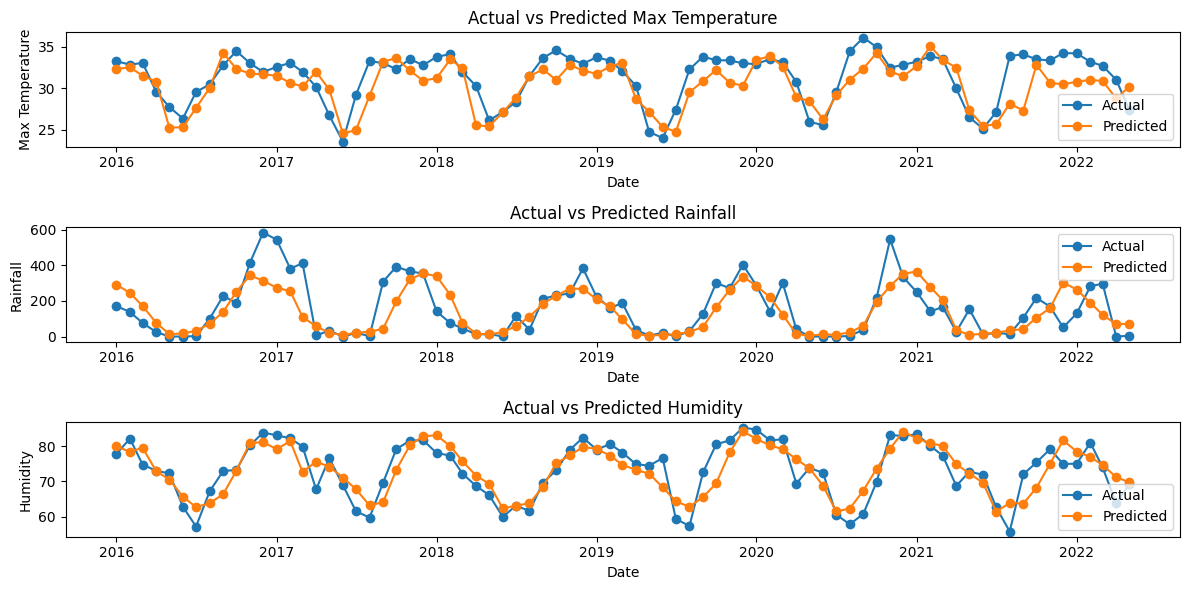

In [107]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = dhaka_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 77

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_dhaka[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_dhaka[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/softcom/pics/' + 'dhkCNN.png')
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2015-08-01            31.08           30.967669             47.0   
1  2015-09-01            32.47           32.926731            111.0   
2  2015-10-01            32.04           31.746904            326.0   
3  2015-11-01            32.74           28.925180            391.0   
4  2015-12-01            31.70           30.154865            518.0   
..        ...              ...                 ...              ...   
77 2022-01-01            33.36           32.939285            238.0   
78 2022-02-01            32.38           32.350372            343.0   
79 2022-03-01            31.98           30.869234            240.0   
80 2022-04-01            30.43           22.948866              0.0   
81 2022-05-01            26.41           23.986977              0.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            64.558205            75.58           73.613

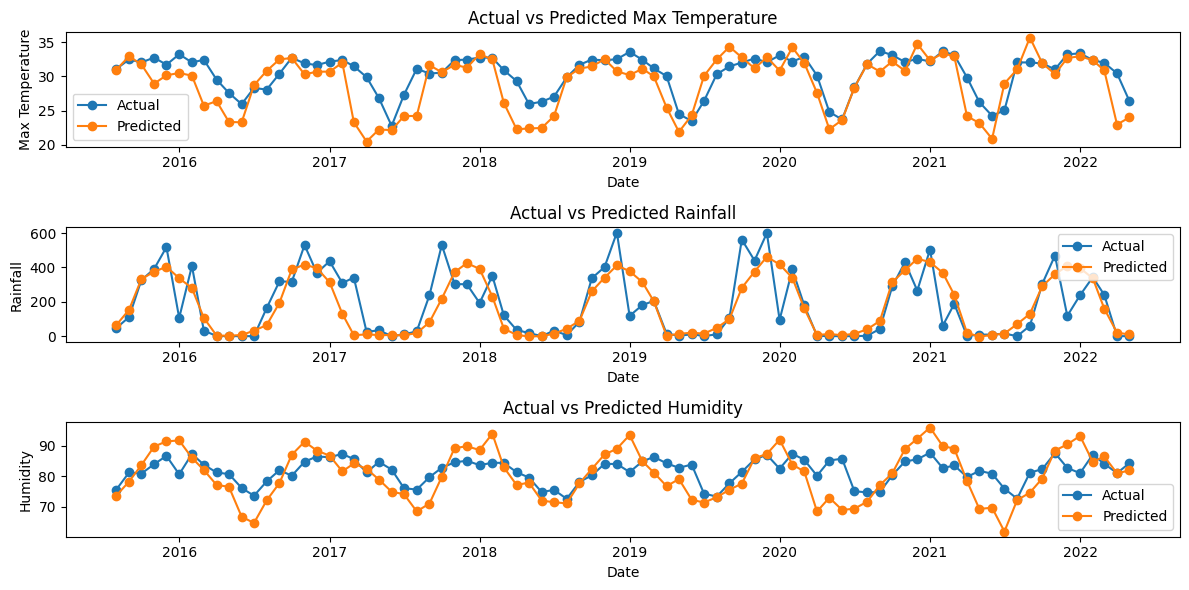

In [92]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = mymen_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 82

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_mymen[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_mymen[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2017-01-01            34.14           32.895561            219.0   
1  2017-02-01            33.93           32.764088            132.0   
2  2017-03-01            31.81           28.858292            237.0   
3  2017-04-01            29.36           27.194670              5.0   
4  2017-05-01            26.18           25.990314             20.0   
..        ...              ...                 ...              ...   
60 2022-01-01            34.71           33.864113            263.0   
61 2022-02-01            34.07           36.860828            329.0   
62 2022-03-01            33.06           38.286907             57.0   
63 2022-04-01            30.33           35.576088              0.0   
64 2022-05-01            26.78           30.858631              1.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0           224.285400            85.71           90.789

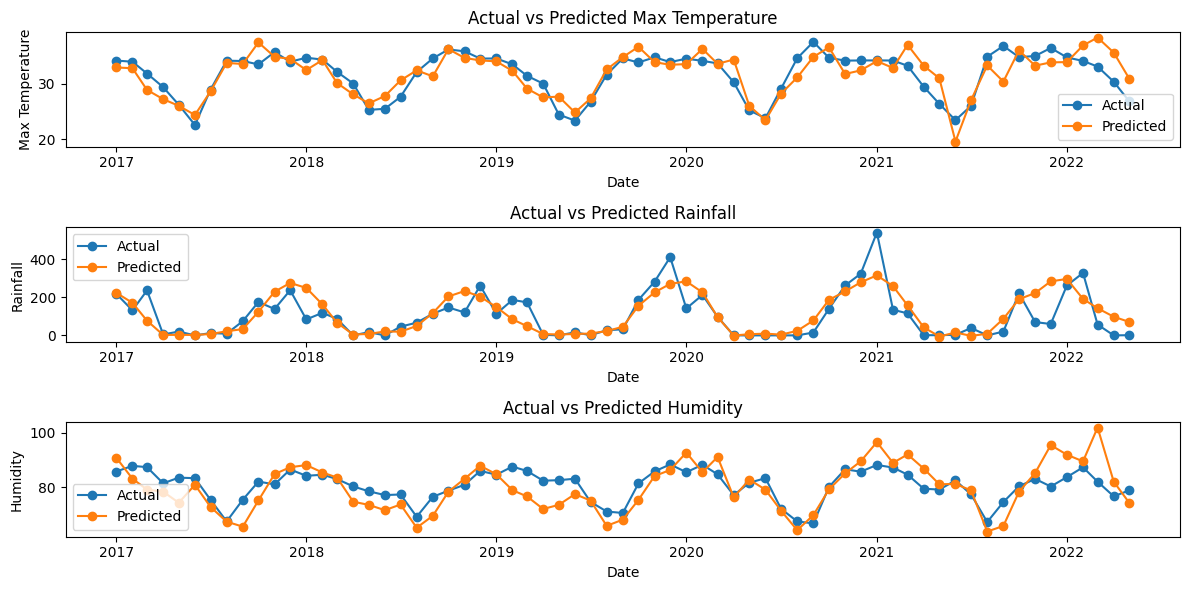

In [93]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = raj_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 65

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_raj[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_raj[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2015-08-01            33.83           33.647354              5.0   
1  2015-09-01            36.31           35.202820             54.0   
2  2015-10-01            35.13           32.049702            350.0   
3  2015-11-01            33.82           33.620747            353.0   
4  2015-12-01            32.33           32.060776            413.0   
..        ...              ...                 ...              ...   
77 2022-01-01            33.42           30.441996            184.0   
78 2022-02-01            33.33           29.210342            350.0   
79 2022-03-01            32.58           30.721975            292.0   
80 2022-04-01            30.66           29.462496              0.0   
81 2022-05-01            27.48           30.152119              0.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            26.048880            74.52           74.457

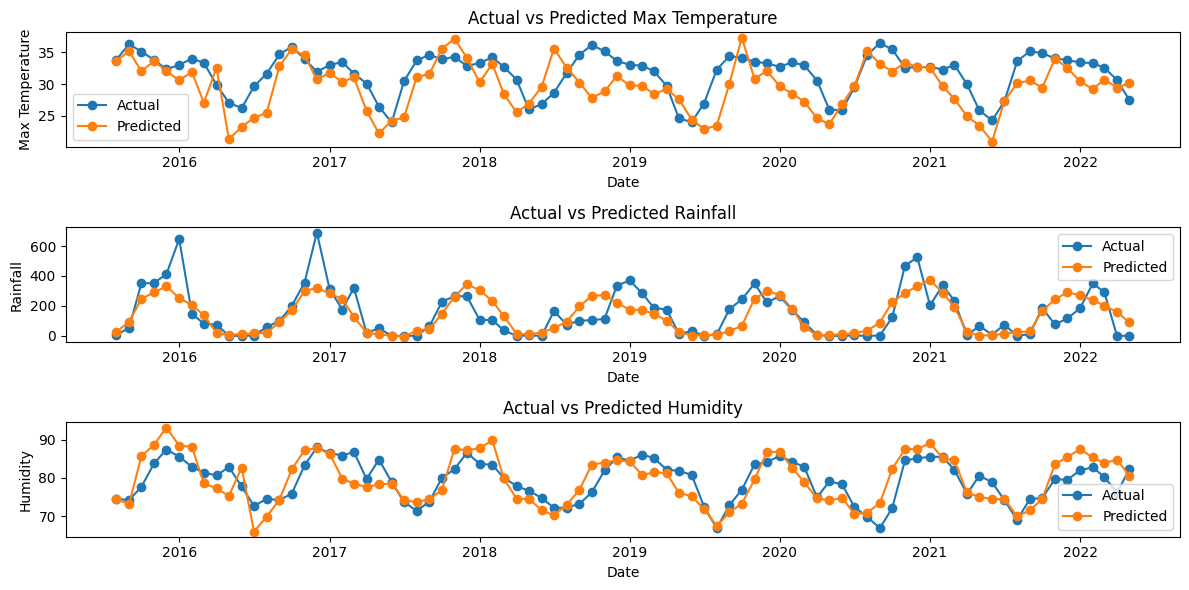

In [94]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = khulna_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 82

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_khulna[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_khulna[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2015-08-01            32.38           30.204367             77.0   
1  2015-09-01            32.67           30.783279             39.0   
2  2015-10-01            32.99           30.512918            253.0   
3  2015-11-01            33.03           29.643682            201.0   
4  2015-12-01            31.29           28.488998            568.0   
..        ...              ...                 ...              ...   
75 2021-11-01            32.14           27.076124            582.0   
76 2021-12-01            33.25           28.411386            271.0   
77 2022-01-01            33.27           29.585173            116.0   
78 2022-02-01            32.55           32.765091            386.0   
79 2022-03-01            32.82           32.523834            154.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            29.640471            72.65           72.834

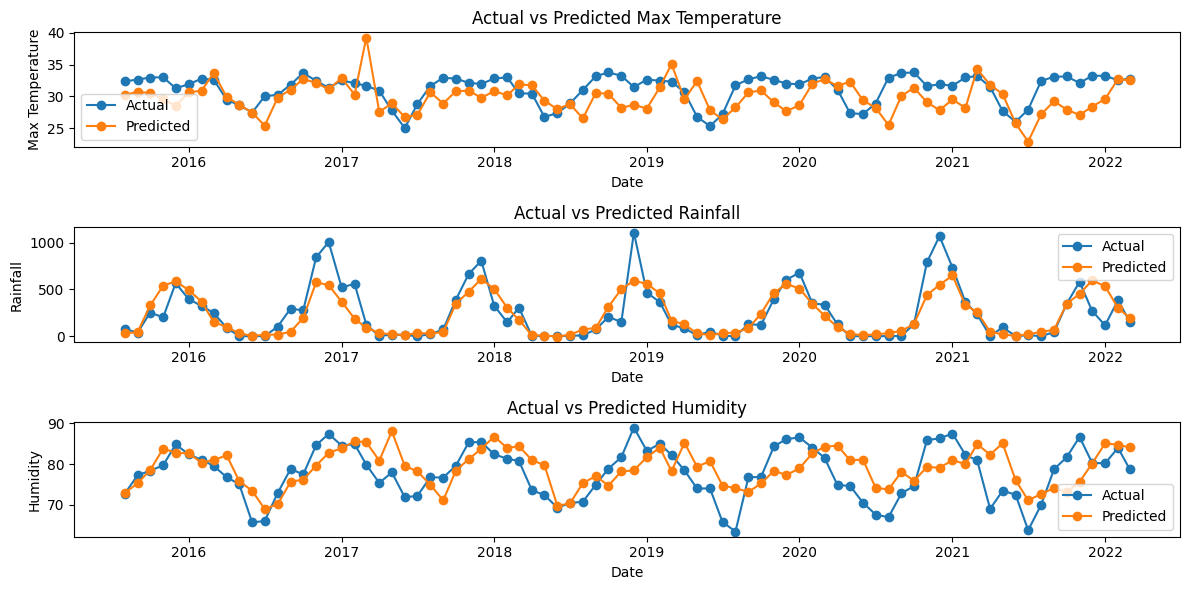

In [96]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = chitt_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 80

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_chitt[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_chitt[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2016-05-01            27.01           26.525471              6.0   
1  2016-06-01            25.27           29.184242              3.0   
2  2016-07-01            27.64           25.190414              0.0   
3  2016-08-01            27.99           34.611893            120.0   
4  2016-09-01            30.37           31.259697            172.0   
..        ...              ...                 ...              ...   
65 2021-10-01            32.09           33.627327            276.0   
66 2021-11-01            31.83           33.864166            585.0   
67 2021-12-01            34.75           30.312223            246.0   
68 2022-01-01            34.07           35.554596            309.0   
69 2022-02-01            32.82           31.049774            164.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0             3.361075            80.48           79.000

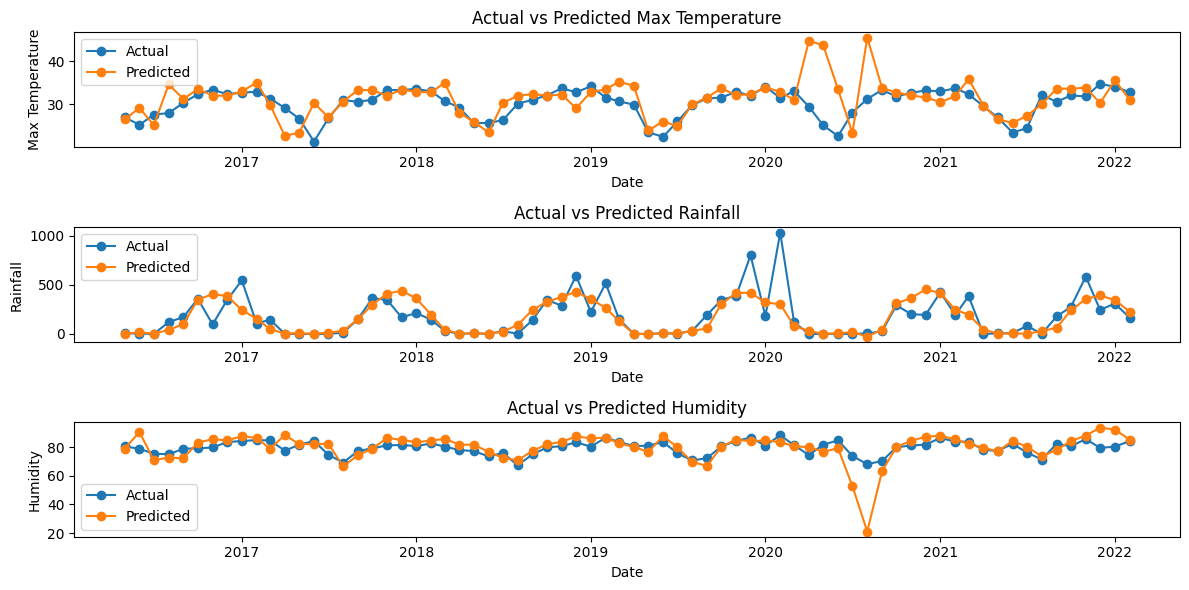

In [100]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = rang_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 70

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_rang[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_rang[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2016-04-01            29.59           29.916920            108.0   
1  2016-05-01            28.62           29.573704              5.0   
2  2016-06-01            27.75           29.234596              0.0   
3  2016-07-01            29.65           29.892984            137.0   
4  2016-08-01            28.06           28.390297            344.0   
..        ...              ...                 ...              ...   
65 2021-09-01            32.06           33.748573            287.0   
66 2021-10-01            31.13           29.445705            902.0   
67 2021-11-01            29.85           28.630428           1485.0   
68 2021-12-01            34.02           26.543568            778.0   
69 2022-01-01            34.30           28.135120            461.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0             6.154070            77.90           71.000

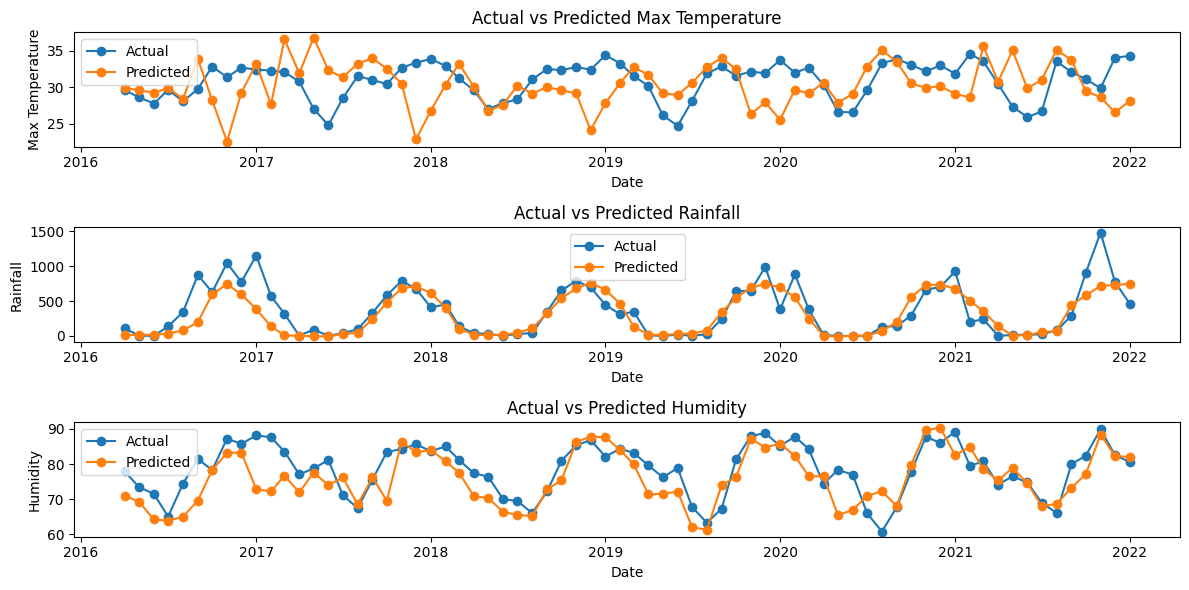

In [103]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = syl_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 70

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_syl[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_syl[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


Actual and Predicted Values:
         Date  Actual Max Temp  Predicted Max Temp  Actual Rainfall  \
0  2015-08-01            33.32           35.764252              8.0   
1  2015-09-01            34.70           33.446117             51.0   
2  2015-10-01            34.09           32.155090            438.0   
3  2015-11-01            33.04           31.448784            318.0   
4  2015-12-01            31.57           30.958330            497.0   
..        ...              ...                 ...              ...   
77 2022-01-01            32.91           32.785370            331.0   
78 2022-02-01            32.85           32.638313            278.0   
79 2022-03-01            32.41           30.783125            476.0   
80 2022-04-01            30.91           28.906475              0.0   
81 2022-05-01            27.94           28.878479              1.0   

    Predicted Rainfall  Actual Humidity  Predicted Humidity  
0            33.331245            76.16           79.703

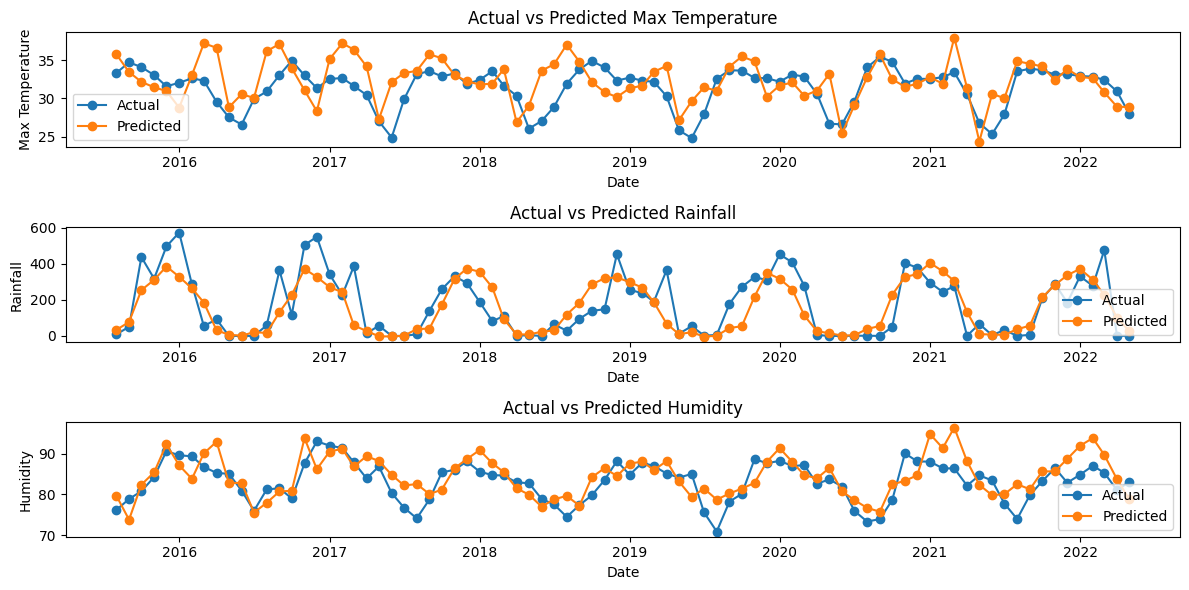

In [104]:
# Create a DataFrame to store actual and predicted values
results_list = []

# Assuming you have a datetime index in your original dataset
dates = bar_test.index

# Assuming you want to predict for the next 7 days
num_days_to_predict = 82

# Iterate through each day in the test set
for i in range(len(dates), len(dates) + num_days_to_predict):
    date = dates[i - len(dates)]  # Use the actual date
    actual_values = y_test_bar[i - len(dates)]  # Actual values for all features
    predicted_values = y_pred_test_bar[i - len(dates)]  # Predicted values for all features

    # Append the results to the list
    results_list.append({
        'Date': date,
        'Actual Max Temp': actual_values[0],  # Assuming max_temp is the first feature
        'Predicted Max Temp': predicted_values[0],
        'Actual Rainfall': actual_values[1],  # Assuming rainfall is the second feature
        'Predicted Rainfall': predicted_values[1],
        'Actual Humidity': actual_values[2],  # Assuming humidity is the third feature
        'Predicted Humidity': predicted_values[2]
    })

# Create the results DataFrame using concat
results_df = pd.concat([pd.DataFrame(results_list)], ignore_index=True)

# Print the results table with dates
print("Actual and Predicted Values:")
print(results_df)

# Plot both actual and predicted values
plt.figure(figsize=(12, 6))

# Plot Max Temp
plt.subplot(3, 1, 1)
plt.plot(results_df['Date'], results_df['Actual Max Temp'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Max Temp'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Max Temperature")
plt.xlabel("Date")
plt.ylabel("Max Temperature")
plt.legend()

# Plot Rainfall
plt.subplot(3, 1, 2)
plt.plot(results_df['Date'], results_df['Actual Rainfall'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Rainfall'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Rainfall")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()

# Plot Humidity
plt.subplot(3, 1, 3)
plt.plot(results_df['Date'], results_df['Actual Humidity'], label='Actual', marker='o')
plt.plot(results_df['Date'], results_df['Predicted Humidity'], label='Predicted', marker='o')
plt.title("Actual vs Predicted Humidity")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()

plt.tight_layout()
plt.show()


In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_metrics_new(y_true, y_pred, city_name):
    mse_max_temp = mean_squared_error(y_true[:, 0], y_pred[:, 0])
    mae_max_temp = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_max_temp = np.sqrt(mse_max_temp)
    mape_max_temp = mean_absolute_percentage_error(y_true[:, 0], y_pred[:, 0])

    mse_rainfall = mean_squared_error(y_true[:, 1], y_pred[:, 1])
    mae_rainfall = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_rainfall = np.sqrt(mse_rainfall)
    mape_rainfall = mean_absolute_percentage_error(y_true[:, 1], y_pred[:, 1])

    mse_humidity = mean_squared_error(y_true[:, 2], y_pred[:, 2])
    mae_humidity = mean_absolute_error(y_true[:, 2], y_pred[:, 2])
    rmse_humidity = np.sqrt(mse_humidity)
    mape_humidity = mean_absolute_percentage_error(y_true[:, 2], y_pred[:, 2])

    print(f"Metrics for {city_name}:")
    print(f"Max Temp - MSE: {mse_max_temp}, MAE: {mae_max_temp}, RMSE: {rmse_max_temp}, MAPE: {mape_max_temp}%")
    print(f"Rainfall - MSE: {mse_rainfall}, MAE: {mae_rainfall}, RMSE: {rmse_rainfall}, MAPE: {mape_rainfall}%")
    print(f"Humidity - MSE: {mse_humidity}, MAE: {mae_humidity}, RMSE: {rmse_humidity}, MAPE: {mape_humidity}%")
    print("\n\n")


In [106]:
# Calculate metrics for Dhaka

calculate_metrics_new(y_test_dhaka, y_pred_test_dhaka, "Dhaka (Test)")

# Calculate metrics for MyMensingh

calculate_metrics_new(y_test_mymen, y_pred_test_mymen, "MyMensingh (Test)")

# Calculate metrics for Rajshahi

calculate_metrics_new(y_test_raj, y_pred_test_raj, "Rajshahi (Test)")

# Calculate metrics for Khulna

calculate_metrics_new(y_test_khulna, y_pred_test_khulna, "Khulna (Test)")

# Calculate metrics for Chittagong

calculate_metrics_new(y_test_chitt, y_pred_test_chitt, "Chittagong (Test)")

# Calculate metrics for Rangpur

calculate_metrics_new(y_test_rang, y_pred_test_rang, "Rangpur (Test)")

# Calculate metrics for Sylhet

calculate_metrics_new(y_test_syl, y_pred_test_syl, "Sylhet (Test)")

# Calculate metrics for Barisal

calculate_metrics_new(y_test_bar, y_pred_test_bar, "Barisal (Test)")


Metrics for Dhaka (Test):
Max Temp - MSE: 4.889044949743583, MAE: 1.7582289272159728, RMSE: 2.2111184838772395, MAPE: 5.5917426960698045%
Rainfall - MSE: 11194.459444893871, MAE: 71.80005607357273, RMSE: 105.80387254204769, MAPE: 180.4678894803448%
Humidity - MSE: 18.0327413843669, MAE: 3.4700862161215245, RMSE: 4.246497543195675, MAPE: 4.884819850447229%



Metrics for MyMensingh (Test):
Max Temp - MSE: 8.982121712330908, MAE: 2.1608555696068743, RMSE: 2.997018804133686, MAPE: 7.302374384036021%
Rainfall - MSE: 13757.02557844079, MAE: 77.32223047316074, RMSE: 117.2903473370285, MAPE: 159.78749822672816%
Humidity - MSE: 38.80269770621419, MAE: 4.95057797315644, RMSE: 6.2291811425109636, MAPE: 6.067867977209009%



Metrics for Rajshahi (Test):
Max Temp - MSE: 5.704975351086862, MAE: 1.88916605083759, RMSE: 2.3885090226094734, MAPE: 6.111468116461889%
Rainfall - MSE: 5664.181017056665, MAE: 51.32853182279147, RMSE: 75.26075349780034, MAPE: 309.8274142917404%
Humidity - MSE: 34.5815229196